In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv
/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import ast
from ast import literal_eval
from scipy import sparse
from sklearn.metrics.pairwise import linear_kernel
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from itertools import combinations

In [4]:
movie_df = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
credit_df = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')

In [5]:
movie_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [6]:
movie_df.shape

(4803, 20)

In [7]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [8]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [9]:
# Include moviews with sufficient votes
sample_movie = movie_df[movie_df.vote_count > movie_df.vote_count.mean()]

# Drop unnecessary columns
sample_movie.drop(['homepage','budget','original_language',
                  'production_companies','production_countries',
                  'release_date','revenue','runtime',
                  'spoken_languages','status','tagline'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
# Kepp records with high popularity (greater than mean)
sample_movie = sample_movie[sample_movie['popularity']>sample_movie.popularity.mean()]

In [11]:
# Use literal_eval to convert str to corresponding dtypes

features = ['genres','keywords']

for f in features:
    sample_movie[f] = sample_movie[f].apply(literal_eval)

In [12]:
# Explode disctionaries 
temp = sample_movie.genres.apply(lambda x: pd.Series({el["id"]: el["name"] for el in x if isinstance(x, list)}))

cols = [12,14,16,18,27,28,35,36,37,53,80,878,9648]
# Concatenate non NaN values
temp['combined'] = temp[cols].apply(lambda row: ', '.join(row.dropna()), axis=1)

# Take only combined values
temp = temp.iloc[:,-1]

sample_movie_2 = pd.concat([sample_movie, temp],axis=1 )

# Drop genres and rename combined

sample_movie_2.drop('genres', axis=1, inplace=True)
sample_movie_2.rename(columns={'combined':'genres'}, inplace=True)
sample_movie_2.head(1)

,id,keywords,original_title,overview,popularity,title,vote_average,vote_count,genres
0,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,Avatar,7.2,11800,"Adventure, Fantasy, Action, Science Fiction"


In [13]:
genre_popularity = sample_movie_2.genres.str.split(',').explode().value_counts().sort_values(ascending=False)

Word Cloud - Genres

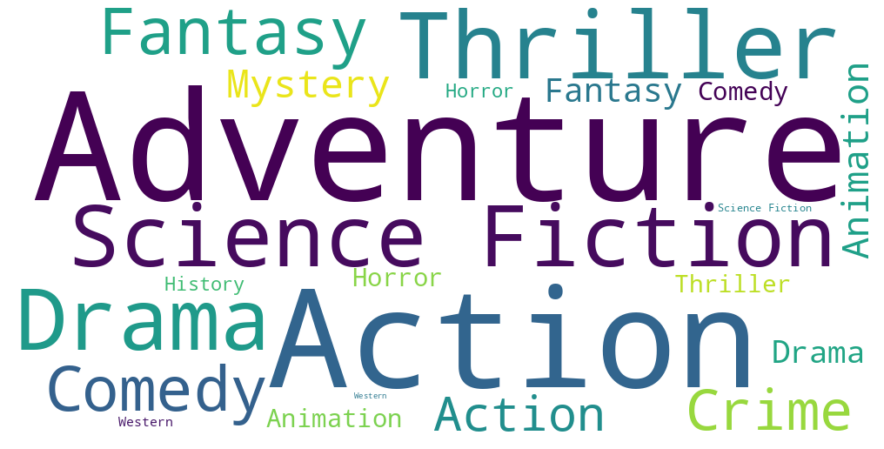

In [14]:
genre_wc = WordCloud(width=1000, height=500,background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())

plt.figure(figsize=(16,8))
plt.imshow(genre_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
sample_movie = sample_movie_2.copy()

In [16]:
# Clean up keywords

def extract_name(s):
    li = []
    for x in s['keywords']:
        li.append(x['name'])
    return li

# Apply function
sample_movie['keywords'] = sample_movie.apply(extract_name,axis=1)

# Remove square brackets
sample_movie.keywords = sample_movie.keywords.str.join(', ')

In [17]:
sample_movie = sample_movie.reset_index(drop=True)

# Recommender System - Genres Only

In [18]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,3) for c in combinations(s.split(','),
                                                                                    r=i)))

genres_matrix = tf.fit_transform(sample_movie['genres'])
genres_matrix.shape
                     

(401, 112)

In [19]:
pd.DataFrame(genres_matrix.todense(), columns=tf.get_feature_names(),
            index=sample_movie.title).sample(5, axis=1).sample(10, axis=0)

,"( Fantasy, Animation)","(Horror, Comedy)","( Thriller,)","( Science Fiction, Mystery)","( Crime,)"
title,,,,,
Spider-Man 3,0.0,0.0,0.000000,0.0,0.000000
Mission: Impossible - Ghost Protocol,0.0,0.0,0.365234,0.0,0.000000
Night at the Museum: Secret of the Tomb,0.0,0.0,0.000000,0.0,0.000000
The Italian Job,0.0,0.0,0.000000,0.0,0.454146
Grease,0.0,0.0,0.000000,0.0,0.000000
Harry Potter and the Philosopher's Stone,0.0,0.0,0.000000,0.0,0.000000
Back to the Future,0.0,0.0,0.000000,0.0,0.000000
Ocean's Eleven,0.0,0.0,0.000000,0.0,0.419129
Jack Reacher,0.0,0.0,0.299605,0.0,0.386168


In [20]:
# Calculate similarity
cs_genre = cosine_similarity(genres_matrix)

In [21]:
cs_genre.shape

(401, 401)

In [22]:
indices = pd.Series(sample_movie.index, index=sample_movie['title']).drop_duplicates()

In [23]:
def give_rec(title, sig=cs_genre):
    idx = indices[title]
    sig_scores = list(enumerate(sig[idx]))
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    sig_scores = sig_scores[1:11]
    movie_indices = [i[0] for i in sig_scores]
    return sample_movie['title'].iloc[movie_indices]

# Recommender System - Overview Only

In [24]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [25]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [26]:
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}

In [27]:
def preprocess_sentences(text):
    text = text.lower()
    temp_sent = []
    words = nltk.word_tokenize(text)
    tags = nltk.pos_tag(words)
    for i, word in enumerate(words):
        if tags[i][1] in VERB_CODES:
            lemmatized = lemmatizer.lemmatize(word,'v')
        else:
            lemmatized = lemmatizer.lemmatize(word)
        if lemmatized not in stop_words and lemmatized.isalpha():
            temp_sent.append(lemmatized)
    finalsent = ' '.join(temp_sent)
    finalsent = finalsent.replace("n't", ' not')
    finalsent = finalsent.replace("'m", ' am')
    finalsent = finalsent.replace("'s", ' is')
    finalsent = finalsent.replace("'re", ' are')
    finalsent = finalsent.replace("'ll",' will')
    finalsent = finalsent.replace("'ve", ' have')
    finalsent = finalsent.replace("'d", 'would')
    return finalsent

In [28]:
sample_movie['overview_processed'] = sample_movie['overview'].apply(preprocess_sentences)
sample_movie.head()

,id,keywords,original_title,overview,popularity,title,vote_average,vote_count,genres,overview_processed
0,19995,"culture clash, future, space war, space colony...",Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,Avatar,7.2,11800,"Adventure, Fantasy, Action, Science Fiction",century paraplegic marine dispatch moon pandor...
1,285,"ocean, drug abuse, exotic island, east india t...",Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,Pirates of the Caribbean: At World's End,6.9,4500,"Adventure, Fantasy, Action",captain barbossa long believe dead come back l...
2,206647,"spy, based on novel, secret agent, sequel, mi6...",Spectre,A cryptic message from Bond’s past sends him o...,107.376788,Spectre,6.3,4466,"Adventure, Action, Crime",cryptic message bond past sends trail uncover ...
3,49026,"dc comics, crime fighter, terrorist, secret id...",The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,The Dark Knight Rises,7.6,9106,"Drama, Action, Thriller, Crime",follow death district attorney harvey dent bat...
4,559,"dual identity, amnesia, sandstorm, love of one...",Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,Spider-Man 3,5.9,3576,"Adventure, Fantasy, Action",seemingly invincible go crop villain include s...


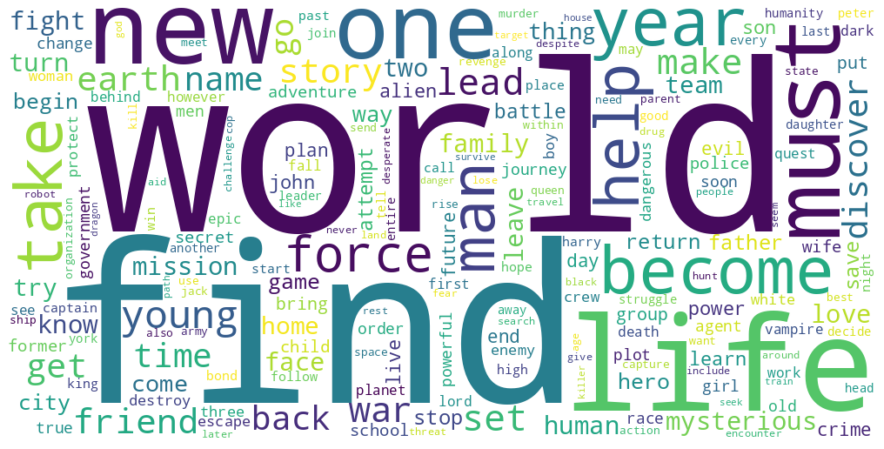

In [29]:
overview_freq = sample_movie.overview_processed.str.split(' ').explode().value_counts().sort_values(ascending=False)
overview_wc = WordCloud(width=1000, height=500,background_color='white')
overview_wc.generate_from_frequencies(overview_freq.to_dict())

plt.figure(figsize=(16,8))
plt.imshow(overview_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [30]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), stop_words='english')
overview_matrix = tf.fit_transform(sample_movie['overview_processed'])

cs_overview = cosine_similarity(overview_matrix, overview_matrix)

In [31]:
def give_rec2(title, cosine_sim = cs_overview):
    index = indices[title]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending=False)
    top_10_movies = similarity_scores.iloc[1:11]
    movie_indices = [i for i in top_10_movies.index]
    return sample_movie['title'].iloc[movie_indices]

# Recommender System - Overview & Genres

In [32]:
combined_matrix = sparse.hstack((overview_matrix, genres_matrix))

cs_overview_genres = linear_kernel(combined_matrix, combined_matrix)

In [33]:
def give_rec3(title, cosine_sim = cs_overview_genres):
    index = indices[title]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending=False)
    top_10_movies = similarity_scores.iloc[1:11]
    movie_indices = [i for i in top_10_movies.index]
    return sample_movie['title'].iloc[movie_indices]

# Recommender System - Keywords only

Word Cloud - Keywords

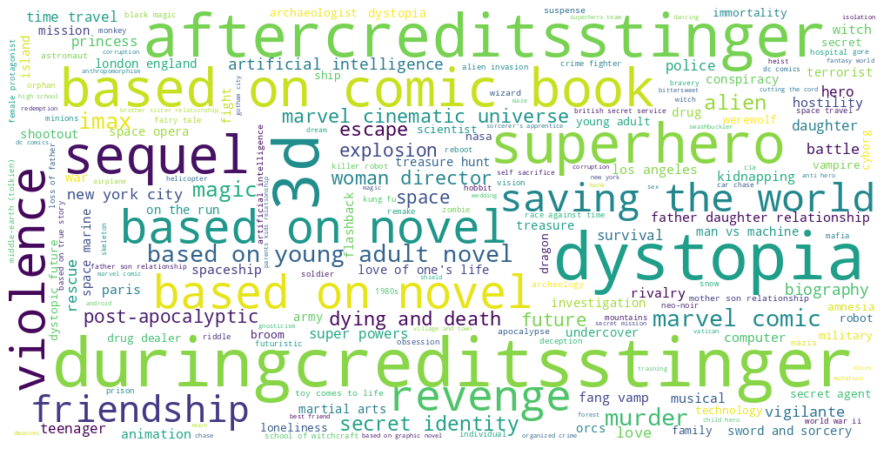

In [34]:
keywords_freq = sample_movie.keywords.str.split(',').explode().value_counts().sort_values(ascending=False)
keywords_wc = WordCloud(width=1000, height=500,background_color='white')
keywords_wc.generate_from_frequencies(keywords_freq.to_dict())

plt.figure(figsize=(16,8))
plt.imshow(keywords_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
tf = TfidfVectorizer(min_df=3, max_features=None, 
                    strip_accents='unicode', analyzer='word',
                    token_pattern= r'\w{1,}', ngram_range=(1,2),
                    stop_words='english')
keywords_matrix = tf.fit_transform(sample_movie['keywords'])
keywords_matrix.shape

(401, 819)

In [36]:
pd.DataFrame(keywords_matrix.todense(), columns=tf.get_feature_names(),
            index=sample_movie.title).sample(5, axis=1).sample(10, axis=0)

,post,suspicion,monkey,redemption,rescue
title,,,,,
Guardians of the Galaxy,0.000000,0.0,0.0,0.0,0.0
The Giver,0.000000,0.0,0.0,0.0,0.0
Snowpiercer,0.153566,0.0,0.0,0.0,0.0
Warcraft,0.000000,0.0,0.0,0.0,0.0
Toy Story,0.000000,0.0,0.0,0.0,0.0
The Fifth Element,0.000000,0.0,0.0,0.0,0.0
The Godfather: Part II,0.000000,0.0,0.0,0.0,0.0
The Adventures of Tintin,0.000000,0.0,0.0,0.0,0.0
WALL·E,0.000000,0.0,0.0,0.0,0.0


In [37]:
cs_keyword = cosine_similarity(keywords_matrix)

In [38]:
def give_rec4(title, sig=cs_keyword):
    idx = indices[title]
    sig_scores = list(enumerate(sig[idx]))
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    sig_scores = sig_scores[1:11]
    movie_indices = [i[0] for i in sig_scores]
    return sample_movie['title'].iloc[movie_indices]

# Recommender System - Genres & Keywords

In [39]:
combined_matrix_gk = sparse.hstack((genres_matrix, keywords_matrix))

cs_genres_keywords = linear_kernel(combined_matrix_gk, combined_matrix_gk)

In [40]:
def give_rec5(title, cosine_sim = cs_genres_keywords):
    index = indices[title]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending=False)
    top_10_movies = similarity_scores.iloc[1:11]
    movie_indices = [i for i in top_10_movies.index]
    return sample_movie['title'].iloc[movie_indices]

# Recommender System - Overview, genres, crew, cast

In [41]:
full_df = sample_movie.merge(credit_df,on='title')

In [42]:
full_df.columns

Index(['id', 'keywords', 'original_title', 'overview', 'popularity', 'title',
       'vote_average', 'vote_count', 'genres', 'overview_processed',
       'movie_id', 'cast', 'crew'],
      dtype='object')

In [43]:
full_df = full_df[['title','overview_processed', 
                   'genres', 'cast','crew']]
full_df.head()

,title,overview_processed,genres,cast,crew
0,Avatar,century paraplegic marine dispatch moon pandor...,"Adventure, Fantasy, Action, Science Fiction","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,Pirates of the Caribbean: At World's End,captain barbossa long believe dead come back l...,"Adventure, Fantasy, Action","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,Spectre,cryptic message bond past sends trail uncover ...,"Adventure, Action, Crime","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,The Dark Knight Rises,follow death district attorney harvey dent bat...,"Drama, Action, Thriller, Crime","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,Spider-Man 3,seemingly invincible go crop villain include s...,"Adventure, Fantasy, Action","[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de..."


In [44]:
def convert(text):
    L = []
    for i in ast.literal_eval(text):
        L.append(i['name']) 
    return L 

In [45]:
full_df.dropna(inplace=True)
full_df['cast'] = full_df['cast'].apply(convert)

In [46]:
full_df['cast'] = full_df['cast'].apply(lambda x:x[0:3])

In [47]:
def fetch_director(text):
    L = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            L.append(i['name'])
    return L 

In [48]:
full_df['crew'] = full_df['crew'].apply(fetch_director)

In [49]:
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1

In [50]:
# Combine first and last name
full_df['cast'] = full_df['cast'].apply(collapse)
full_df['crew'] = full_df['crew'].apply(collapse)

In [51]:
# Remove square brackets
full_df.cast = full_df.cast.str.join(', ')
full_df.crew = full_df.crew.str.join(', ')

In [52]:
full_df.head()

,title,overview_processed,genres,cast,crew
0,Avatar,century paraplegic marine dispatch moon pandor...,"Adventure, Fantasy, Action, Science Fiction","SamWorthington, ZoeSaldana, SigourneyWeaver",JamesCameron
1,Pirates of the Caribbean: At World's End,captain barbossa long believe dead come back l...,"Adventure, Fantasy, Action","JohnnyDepp, OrlandoBloom, KeiraKnightley",GoreVerbinski
2,Spectre,cryptic message bond past sends trail uncover ...,"Adventure, Action, Crime","DanielCraig, ChristophWaltz, LéaSeydoux",SamMendes
3,The Dark Knight Rises,follow death district attorney harvey dent bat...,"Drama, Action, Thriller, Crime","ChristianBale, MichaelCaine, GaryOldman",ChristopherNolan
4,Spider-Man 3,seemingly invincible go crop villain include s...,"Adventure, Fantasy, Action","TobeyMaguire, KirstenDunst, JamesFranco",SamRaimi


In [53]:
full_df['bow'] = full_df['overview_processed'] + ' ' + full_df['genres'] + ' ' + full_df['cast'] + ' ' + full_df['crew']

In [54]:
full_df['bow'] = full_df['bow'].str.replace(",","")

In [55]:
full_df.iloc[0,-1]

'century paraplegic marine dispatch moon pandora unique mission become torn follow order protect alien civilization Adventure Fantasy Action Science Fiction SamWorthington ZoeSaldana SigourneyWeaver JamesCameron'

In [56]:
tf = TfidfVectorizer(min_df=3, max_features=None, 
                    strip_accents='unicode', analyzer='word',
                    token_pattern= r'\w{1,}', ngram_range=(1,2),
                    stop_words='english')
bow_matrix = tf.fit_transform(full_df['bow'])
bow_matrix.shape

(401, 1218)

In [57]:
cs_bow = cosine_similarity(keywords_matrix)

In [58]:
def give_rec6(title, sig=cs_bow):
    idx = indices[title]
    sig_scores = list(enumerate(sig[idx]))
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    sig_scores = sig_scores[1:11]
    movie_indices = [i[0] for i in sig_scores]
    return full_df['title'].iloc[movie_indices]

In [59]:
# Based on votes from 6 recommenders, give the most popular 10 movies 
def final_rec(title):
    counter = []
    recommenders = [give_rec, give_rec2, give_rec3,
                  give_rec4, give_rec5, give_rec6]
    for r in recommenders:
        for i in r(title).values:
            counter.append(i)
    counter_df = pd.DataFrame({'title':counter})
    counter_df['vote'] = 1
    final_counter = pd.DataFrame(counter_df.groupby('title')['vote'].sum()).reset_index().sort_values('vote', ascending=False)
    final_merged = pd.merge(final_counter,
                            sample_movie[['title',
                                          'vote_average',
                                          'popularity']],
                            on='title',
                            how='left').sort_values(['vote', 
                                                     'vote_average',
                                                     'popularity'], ascending = (False,False,False))
    print('=========== Recommendation ===========')
    return final_merged.iloc[:10,:]

In [60]:
final_rec('Minions')

=========== Recommendation ===========


,title,vote,vote_average,popularity
0,Wreck-It Ralph,5,7.1,62.341073
1,Penguins of Madagascar,5,6.5,84.366984
4,Despicable Me,3,7.1,113.858273
6,Ice Age,3,7.1,99.561972
5,Despicable Me 2,3,7.0,136.886704
2,Kung Fu Panda,3,6.9,84.689648
10,A Bug's Life,3,6.8,87.350802
3,Cars,3,6.6,82.643036
9,Ice Age: The Meltdown,3,6.5,85.115058
8,Ice Age: Dawn of the Dinosaurs,3,6.5,69.457898


In [61]:
give_rec('Minions') # genre-based

61                     Wreck-It Ralph
109            Penguins of Madagascar
110                     Kung Fu Panda
159        Ice Age: Continental Drift
172    Ice Age: Dawn of the Dinosaurs
200             Ice Age: The Meltdown
204                           Minions
206                              Cars
217                           Ice Age
260                      A Bug's Life
Name: title, dtype: object

In [62]:
give_rec2('Minions') # overview-based

324    Home Alone 2: Lost in New York
168                   The Incredibles
197                   Despicable Me 2
29                       TRON: Legacy
213                     Despicable Me
234                 London Has Fallen
176                            Pixels
54                         Iron Man 2
235                    The Lego Movie
59                       Tomorrowland
Name: title, dtype: object

In [63]:
give_rec3('Minions') # both genres & overview

109            Penguins of Madagascar
159        Ice Age: Continental Drift
200             Ice Age: The Meltdown
172    Ice Age: Dawn of the Dinosaurs
61                     Wreck-It Ralph
110                     Kung Fu Panda
47                                 Up
206                              Cars
217                           Ice Age
260                      A Bug's Life
Name: title, dtype: object

In [64]:
give_rec4('Minions') # keyword-based

197                       Despicable Me 2
109                Penguins of Madagascar
392                             Insidious
213                         Despicable Me
111                               Ant-Man
61                         Wreck-It Ralph
121    Sherlock Holmes: A Game of Shadows
84                   Thor: The Dark World
20             Captain America: Civil War
139                300: Rise of an Empire
Name: title, dtype: object

In [65]:
give_rec5('Minions') # both genres & keywords

109            Penguins of Madagascar
61                     Wreck-It Ralph
206                              Cars
172    Ice Age: Dawn of the Dinosaurs
110                     Kung Fu Panda
260                      A Bug's Life
47                                 Up
159        Ice Age: Continental Drift
200             Ice Age: The Meltdown
217                           Ice Age
Name: title, dtype: object

In [66]:
give_rec6('Minions') # Overview, genres, cast, crew

197                       Despicable Me 2
109                Penguins of Madagascar
392                             Insidious
213                         Despicable Me
111                               Ant-Man
61                         Wreck-It Ralph
121    Sherlock Holmes: A Game of Shadows
84                   Thor: The Dark World
20             Captain America: Civil War
139                300: Rise of an Empire
Name: title, dtype: object